In [26]:
%load_ext autoreload
%autoreload 2

from led_controllers_utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"
leds_csv = load_spectral_dict_from_csv("IlluminationData.csv")
save_obj(leds_csv, "./IlluminationData.pkl")
all_leds = [c for c in leds_csv if c != "x_axis"]

In [6]:
                               ### Selecting Leds ###
led_success = False
while not led_success:
    # Affichage compact
    print("\nPlease select LEDs :")
    print("\n".join(f"{i}. {led}" for i, led in enumerate(all_leds, 1)))

    user_input = input("\nEnter numbers (separated by space, comma, etc.): ")
    try :
        # 2. Le "secret" : re.findall extrait tous les nombres, peu importe le délimiteur
        choices = [int(n) for n in re.findall(r'\d+', user_input)]

        # 3. Filtrage et récupération en une ligne
        selected_leds = [all_leds[i-1] for i in choices if 1 <= i <= len(all_leds)]

        if selected_leds:
            print(f"\nYou selected: {', '.join(selected_leds)}")
            led_success = True
    except:
        print("Invalid selection, please try again.")
        pass


Please select LEDs :
1. Violet
2. Blue
3. Green
4. Yellow
5. Red
6. test

Enter numbers (separated by space, comma, etc.): 3 4 5

You selected: Green, Yellow, Red


In [27]:
get_latest_sheet_name?

In [7]:
corrections = get_corrections(selected_LEDs=selected_leds)



--- CORRECTION PHASE ---
Power of Green LED at 5V (Current: 0.35 mW): 
Power of Yellow LED at 5V (Current: 0.87 mW): 
Power of Red LED at 5V (Current: 21.5 mW): 


Current file for calibration : 
./calibration_5_colors_w_MEA_20230403.xlsx
Sheet : 20250309 

Souhaitez-vous changer de fichier ? : y


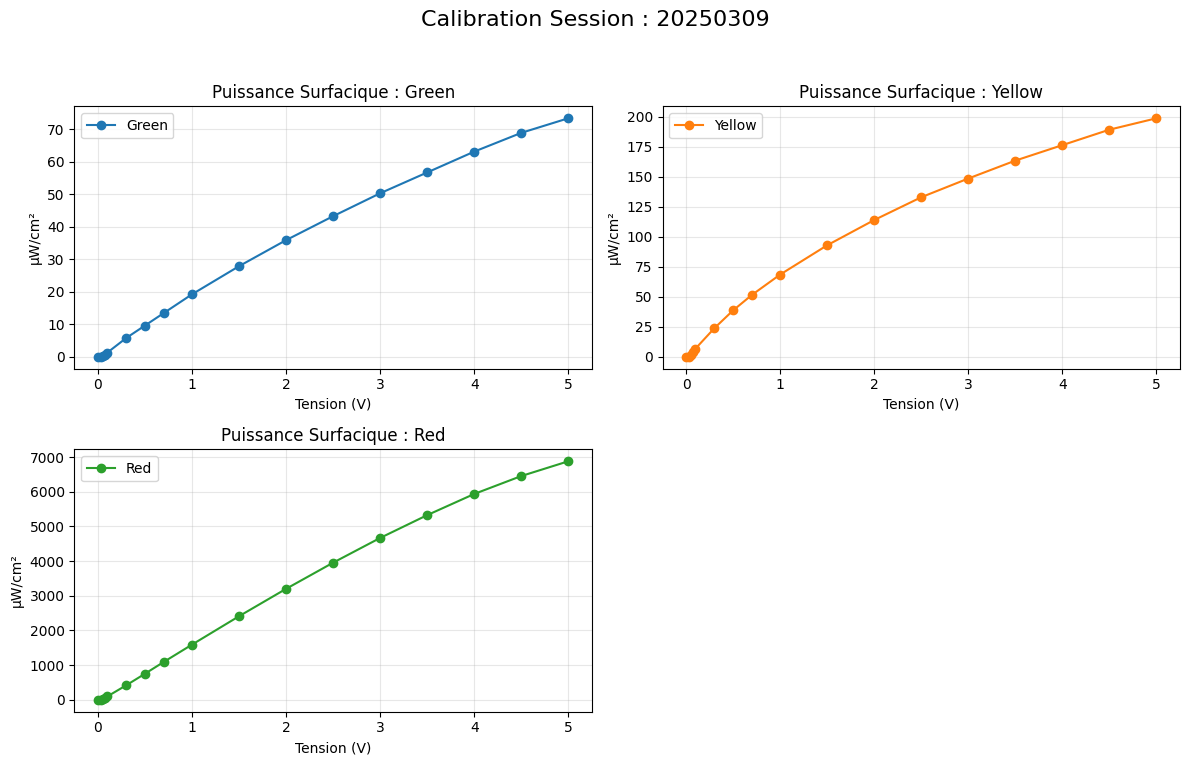

In [31]:
calib_success = False
while not calib_success:
    try:
        print(f'Current file for calibration : \n{calibration_file}\nSheet : {get_latest_sheet_name(calibration_file)} \n')

        response = input('Souhaitez-vous changer de fichier ? : ').lower()
        if response in ["yes", "y", "oui", "o", "si"]:
            root = tk.Tk()
            root.withdraw()
            file_path = filedialog.askopenfilename(title="Select a calibration file")
            root.destroy()
            if file_path:
                calibration_file = file_path

        calibration = charge_calibration(calibration_file, corrections, selected_LEDs=selected_leds, verbose=True)
        calib_success = True # Sortie de boucle si le chargement réussit
    except Exception as e:
        print(f"\nErreur : {e}\n") # Affiche l'erreur et recommence la boucle



--- CORRECTION PHASE ---
Power of Yellow LED at 5V (Current: 0.87 mW): 
Power of Red LED at 5V (Current: 21.5 mW): 
Power of test LED at 5V (Current: 7000.0 mW): 


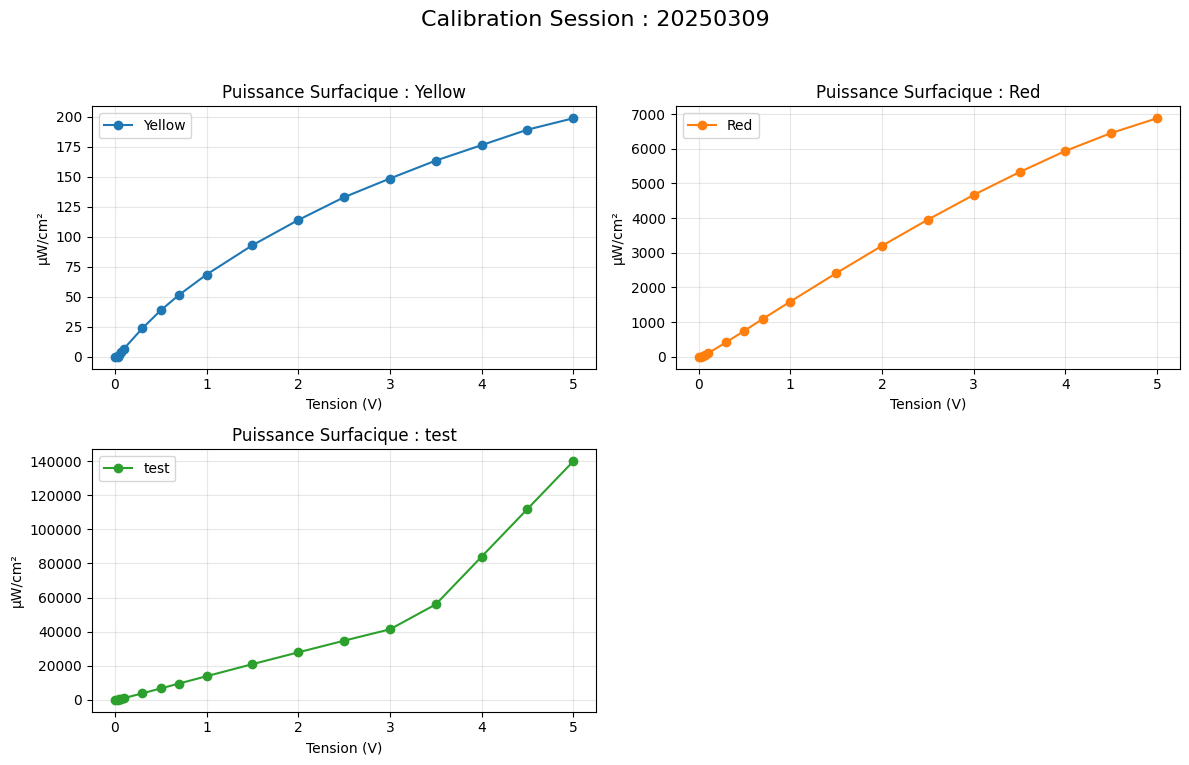

In [12]:
calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"

corrections = get_corrections(selected_LEDs=selected_leds)
save_correction_to_txt(corrections)

calibration = charge_calibration(calibration_file, corrections, selected_LEDs=selected_leds, verbose=True)

In [15]:
file_path = './Example_PowerList.txt'
# On remplace l'extension et le nom pour le fichier de sortie
output_file_path = file_path.replace('.txt', '.csv').replace('PowerList', 'VoltageList')

# Calcul du nombre de lignes pour la barre de progression tqdm
total_lines = sum(1 for _ in open(file_path, 'r'))

with open(file_path, 'r') as file, open(output_file_path, 'w') as output_file:
    for line in tqdm(file, desc='Converting Powers to Voltage', total=total_lines):
        # Extraction des puissances de la ligne (split par espace ou tab)
        Ptot = list(map(float, line.split()))

        # Vérification de cohérence entre le fichier texte et les LEDs sélectionnées
        if len(Ptot) != len(selected_leds):
             raise ValueError(f"Erreur de dimension : {len(Ptot)} colonnes dans le texte vs {len(selected_leds)} LEDs.")

        # Calcul des tensions avec ta fonction habituelle
        # Note : voltage doit être un tableau numpy ou une liste
        voltage = get_voltages(Ptot, calibration, selected_leds)

        # Création de la ligne CSV : on joint les valeurs par des virgules
        # f"{v:f}" permet d'éviter la notation scientifique (ex: 1e-05) pour rester lisible
        csv_line = ",".join(f"{v:f}" for v in voltage)

        # Écriture de la ligne suivie d'un retour à la ligne
        output_file.write(csv_line + "\n")

print(f"\nOutput file contains   {total_lines} colors   and saved at :\n{os.path.normpath(output_file_path)} \n")


Converting Powers to Voltage:   0%|          | 0/11 [00:00<?, ?it/s]


Output file contains   11 colors   and saved at :
Example_VoltageList.csv 




--- CORRECTION PHASE ---
Power of Violet LED at 5V (Current: 5.0 mW): 
Power of Yellow LED at 5V (Current: 0.87 mW): 
Power of test LED at 5V (Current: 7000.0 mW): 


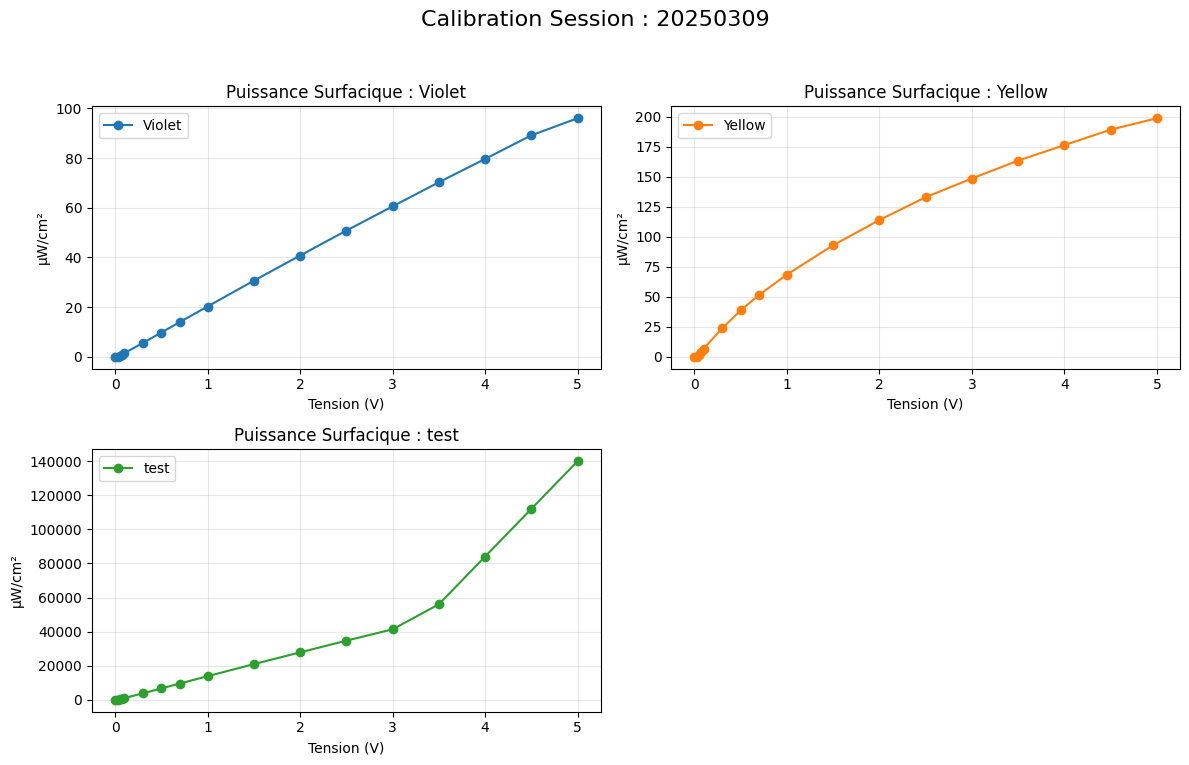

LED Power Mix:
Violet: 0.38 µW/cm²
Yellow: 2.28 µW/cm²
test: 0.00 µW/cm²

Ptot with 3 LED Power Values (µW/cm²):
Violet: 0.375
Yellow: 2.284
test: 0.000

Isomerisation rate:
Scones: 5.4e+02
Mela: 5.6e+03
Rods: 2.0e+04
Mcones: 1.0e+04
RedOpsin: 1.0e+02


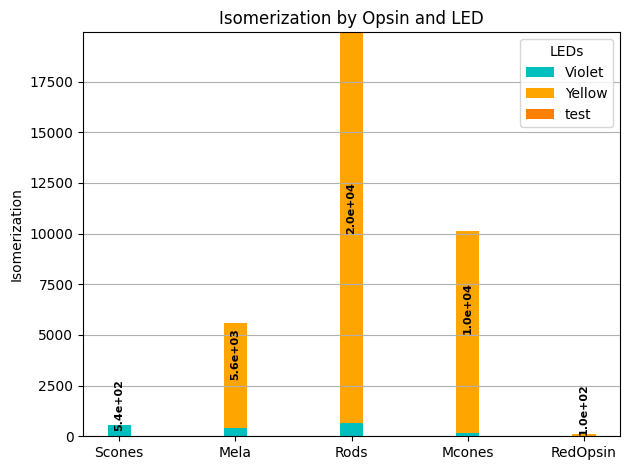

array([0.04522394, 0.05686004, 0.        ])

In [10]:
pr_data = load_spectral_dict_from_csv("./PhotoReceptorData.csv") 
save_obj(pr_data, "./PhotoReceptorData.pkl")

isomerisation_target = {
    "Scones":5e2,
    "Mcones":1e4,
    'Rods':2e4
}
selected_LEDs = ['Violet', 'Yellow', 'test']

corrections = get_corrections(selected_LEDs)
calibration = charge_calibration(calibration_file, corrections, selected_LEDs=selected_LEDs, verbose=True)

Ptot_solution = get_mix_color(isomerisation_target, selected_LEDs = selected_LEDs, ledDATA_path = './IlluminationData.pkl')

plot_isomerisations([Ptot_solution], selected_LEDs = selected_LEDs, colors={'Violet':'c','Yellow':'orange'},ledDATA_path = './IlluminationData.pkl')
plt.show()
plt.close('all')
get_voltages(Ptot_solution, calibration, selected_LEDs)